## **1. Download CSV Files & Load Data into SQL (Python & SQL)**

In [1]:

import numpy as np
import pandas as pd
import pymysql 
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load CSV
customers = pd.DataFrame()
customer_journey = pd.DataFrame()
customer_reviews = pd.DataFrame()
engagement_data = pd.DataFrame()
geography = pd.DataFrame()
products = pd.DataFrame()

customers = pd.read_csv("C:/Users/vasan/DS/customers.csv")
customer_journey = pd.read_csv("C:/Users/vasan/DS/customer_journey.csv")
customer_reviews = pd.read_csv("C:/Users/vasan/DS/customer_reviews.csv")
engagement_data = pd.read_csv("C:/Users/vasan/DS/engagement_data.csv")
geography = pd.read_csv("C:/Users/vasan/DS/geography.csv")
products = pd.read_csv("C:/Users/vasan/DS/products.csv")

In [3]:
# Assigning datasets and Primary key list to the list to loop through data insertion into database
df_list = ['customers','customer_journey','customer_reviews','geography','products','engagement_data']
PK_list = ['CustomerID','JourneyID','ReviewID','GeographyID','ProductID','EngagementID']

In [5]:
# Database connection
myconnection = pymysql.connect(host='localhost', user='root', passwd='Vasanth@1', database="shopeasy")
cursor = myconnection.cursor()

# Define dtype mapping
dtype_mapping = {
    'int64': 'INTEGER',
    'float64': 'FLOAT',
    'object': 'TEXT',
    'datetime64[ns]': 'DATETIME',
    'bool': 'BOOLEAN'
}

for datasetname in df_list:
    df = globals()[datasetname]

    # Map pandas dtypes to MySQL types
    dtype = [dtype_mapping[str(i)] for i in df.dtypes]
    table_column = ",".join(f"{i} {j}" for i, j in zip(df.columns, dtype))
    
    # Get table name
    table_name = datasetname
    
    # Create table
    cursor.execute(f"CREATE TABLE IF NOT EXISTS {table_name} ({table_column})")
    
     # Prepare SQL insert query
    columns = ", ".join(df.columns)
    placeholders = ", ".join(["%s"] * len(df.columns))
    sql_query = f"INSERT INTO {table_name} ({columns}) VALUES ({placeholders})"
    
    # Convert DataFrame values into tuples
    data_tuples = [tuple(None if pd.isna(value) else value for value in row) for row in df.to_numpy()]
    
    # Insert data efficiently
    cursor.executemany(sql_query, data_tuples)
    myconnection.commit()

    print(f"Data successfully inserted into {table_name}")

Data successfully inserted into customers
Data successfully inserted into customer_journey
Data successfully inserted into customer_reviews
Data successfully inserted into geography
Data successfully inserted into products
Data successfully inserted into engagement_data


## **2. Data Extraction & Transformation**

In [6]:
# Setting Primary Key for all the tables and assigning Foreign key to the customerID at customer reviews and journey datasets
cursor = myconnection.cursor()
for i in range(len(df_list)):
  tabname = df_list[i]
  colname = PK_list[i]
  sql_query = f"Alter Table {tabname} ADD PRIMARY KEY ({colname})"
  if i == 1 or i == 2:
        q = f"ALTER TABLE {tabname} ADD CONSTRAINT {tabname}_FK FOREIGN KEY (CustomerID) REFERENCES customers(CustomerID)"
        cursor.execute(q)
        myconnection.commit()
  cursor.execute(sql_query)
  myconnection.commit()

In [29]:
# Data Cleaning
customer_journey = customer_journey.fillna(0)
engagement_data['ContentType'] = list(map(lambda x: x.capitalize(), engagement_data['ContentType']))

## **3. Customer Journey & Engagement Analysis**

**At What stage customers are dropping off in their journey**

In [7]:
q = '''
SELECT C.CustomerID, C.CustomerName, C.Gender, C.Age, G.Country, G.City, P.ProductName, P.Price, J.VisitDate, J.Action, J.Stage
FROM customers as C
INNER JOIN geography as G on G.GeographyID = C.GeographyID
INNER JOIN customer_journey as J on J.CustomerID = C.CustomerID
INNER JOIN products as P on P.ProductID = J.ProductID
WHERE J.Action = 'Drop-off'
ORDER by C.CustomerID;

'''
result = pd.read_sql_query(q, myconnection)
result

C:\Users\vasan\AppData\Local\Temp\ipykernel_13320\1728174181.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(q, myconnection)


,CustomerID,CustomerName,Gender,Age,Country,City,ProductName,Price,VisitDate,Action,Stage
0,1,Emma Anderson,Male,50,Germany,Berlin,Basketball,225.12,2024-03-17,Drop-off,Checkout
1,9,Emily Thomas,Male,29,Austria,Vienna,Ski Boots,340.20,2024-11-19,Drop-off,checkout
2,15,Emma Martinez,Male,32,Switzerland,Zurich,Baseball Glove,327.36,2025-08-07,Drop-off,Checkout
3,23,Isabella Garcia,Female,37,Italy,Rome,Ice Skates,37.56,2023-08-22,Drop-off,Checkout
4,30,Alex Garcia,Female,33,Belgium,Brussels,Boxing Gloves,262.32,2024-02-18,Drop-off,checkout
5,33,David Thomas,Male,22,Spain,Madrid,Volleyball,42.80,2025-05-28,Drop-off,Checkout
6,38,John Garcia,Male,28,Spain,Madrid,Surfboard,275.43,2024-06-18,Drop-off,Checkout
7,40,Olivia Thomas,Female,67,Germany,Berlin,Boxing Gloves,262.32,2023-07-13,Drop-off,Checkout
8,43,Olivia Hernandez,Male,53,Sweden,Stockholm,Football Helmet,44.75,2023-08-22,Drop-off,Checkout
9,58,Jane Williams,Male,34,Austria,Vienna,Boxing Gloves,262.32,2024-03-07,Drop-off,Checkout


**Identify drop-off points in the customer journey.**

In [32]:
# Customers are dropping during check-out stage
q = '''
SELECT Stage, count(*) as "No Of Drop_Off"
FROM customer_journey
WHERE Action = "Drop-off"
GROUP BY Stage;
'''
result = pd.read_sql_query(q, myconnection)
result

C:\Users\vasan\AppData\Local\Temp\ipykernel_23104\788646280.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(q, myconnection)


,Stage,No Of Drop_Off
0,Checkout,14


**Find common actions leading to successful conversions.**

In [45]:
q = '''
SELECT *, count(Action) OVER(PARTITION BY Action) as ActionCount,
Round(avg(Duration) OVER(PARTITION BY Action),2) as ActionAvgDuration
FROM customer_journey
WHERE Not (Action = "Drop-off");
'''
result = pd.read_sql_query(q, myconnection)
result

C:\Users\conta\AppData\Local\Temp\ipykernel_17788\3357542761.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(q, myconnection)


,JourneyID,CustomerID,ProductID,VisitDate,Stage,Action,Duration,ActionCount,ActionAvgDuration
0,49,93,14,2023-04-09,Homepage,Click,69.0,22,149.82
1,5,91,10,2023-02-11,Homepage,Click,156.0,22,149.82
2,35,60,19,2023-06-21,homepage,Click,162.0,22,149.82
3,66,52,2,2023-11-16,homepage,Click,242.0,22,149.82
4,22,12,1,2025-11-19,Homepage,Click,20.0,22,149.82
...,...,...,...,...,...,...,...,...,...
81,96,22,9,2024-07-28,ProductPage,View,212.0,58,174.57
82,97,92,19,2025-05-26,homepage,View,203.0,58,174.57
83,29,12,17,2025-06-01,Homepage,View,205.0,58,174.57
84,30,48,2,2023-05-03,ProductPage,View,242.0,58,174.57


**Calculate average duration per stage for engagement insights**

In [127]:
q = '''
SELECT J.Stage, Round(avg(J.Duration),2) 'AverageVistedTime'
FROM customer_journey as J where J.Duration > 0 group by J.Stage order by 2 DESC;
'''
result = pd.read_sql_query(q, myconnection)
result

C:\Users\conta\AppData\Local\Temp\ipykernel_22236\3397145906.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(q, myconnection)


,Stage,AverageVistedTime
0,ProductPage,182.77
1,Homepage,160.54
2,Checkout,150.17


**Most Engaging content**

In [157]:
q = '''
SELECT 
    ContentType, Round(Sum(Likes)) as TotalLikes, SUM(SUBSTR(ViewsClicksCombined,1,INSTR(ViewsClicksCombined,"-")-1)) as TotalViews,
    SUM(SUBSTR(ViewsClicksCombined,INSTR(ViewsClicksCombined,"-")+1,length(ViewsClicksCombined))) as TotalClicks
FROM engagement_data
GROUP BY ContentType
ORDER BY TotalLikes DESC;
'''
result = pd.read_sql_query(q, myconnection)
result

C:\Users\conta\AppData\Local\Temp\ipykernel_17788\3714764997.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(q, myconnection)


,ContentType,TotalLikes,TotalViews,TotalClicks
0,video,3473.0,64073.0,13803.0
1,Blog,2999.0,65977.0,14300.0
2,Socialmedia,2594.0,59936.0,12498.0
3,newsletter,1380.0,37059.0,6350.0


**Most Liked Product**

In [160]:
q = '''
SELECT 
    P.ProductName, Round(Sum(E.Likes)) as TotalLikes, SUM(SUBSTR(E.ViewsClicksCombined,1,INSTR(E.ViewsClicksCombined,"-")-1)) as TotalViews,
    SUM(SUBSTR(E.ViewsClicksCombined,INSTR(E.ViewsClicksCombined,"-")+1,length(E.ViewsClicksCombined))) as TotalClicks
FROM engagement_data as E
JOIN products as P on P.ProductID = E.ProductID
GROUP BY P.ProductName
ORDER BY TotalLikes DESC;
'''
result = pd.read_sql_query(q, myconnection)
result

C:\Users\conta\AppData\Local\Temp\ipykernel_17788\1383646501.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(q, myconnection)


,ProductName,TotalLikes,TotalViews,TotalClicks
0,Kayak,1231.0,26456.0,6073.0
1,Running Shoes,1160.0,23158.0,6199.0
2,Football Helmet,929.0,13763.0,3223.0
3,Baseball Glove,903.0,7241.0,2484.0
4,Hockey Stick,835.0,15447.0,2548.0
5,Climbing Rope,786.0,15100.0,2906.0
6,Cycling Helmet,618.0,13658.0,2302.0
7,Yoga Mat,617.0,9641.0,3183.0
8,Surfboard,594.0,10025.0,2804.0
9,Fitness Tracker,456.0,13956.0,3206.0


## **4.Customer Reviews Analysis (SQL & Python):**

In [34]:
#Most purchased product and customer shown interest to leave the reviews
q = '''
SELECT 
    P.ProductID, P.ProductName, P.Price,
    AVG(R.Rating) AS AvgRating,
    COUNT(R.ReviewID) AS ReviewCount,
    Round(sum(P.Price),2) as TotalSales
FROM customer_reviews as R
JOIN products as P on P.ProductID = R.ProductID
GROUP BY P.ProductID, P.ProductName, P.Price
ORDER BY ReviewCount DESC, AvgRating DESC;
'''
result = pd.read_sql_query(q, myconnection)

C:\Users\vasan\AppData\Local\Temp\ipykernel_23104\158077663.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(q, myconnection)


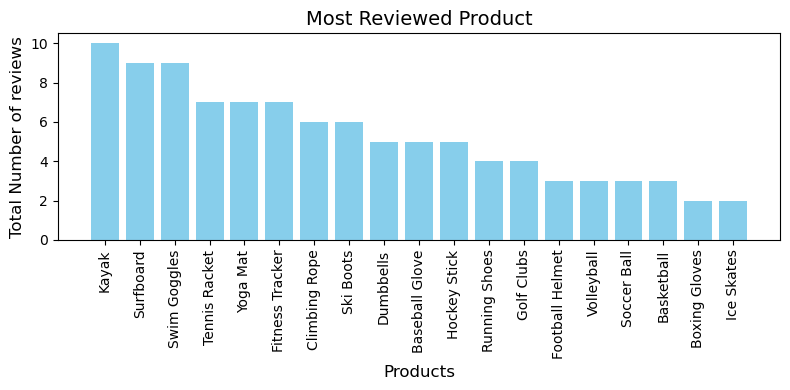

In [101]:
# Create a bar chart for ProductName and ReviewCount
plt.figure(figsize=(8, 4))

# Sort the result by 'ReviewCount' in descending order
sorted_result = result.sort_values(by='ReviewCount', ascending=False)

# Plotting the bar chart
plt.bar(sorted_result['ProductName'], sorted_result['ReviewCount'], color='skyblue')

# Adding labels and title
plt.title('Most Reviewed Product', fontsize=14)
plt.xlabel('Products', fontsize=12)
plt.ylabel('Total Number of reviews', fontsize=12)

# Rotating the x-axis labels for readability
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.show()

**Identify highest-rated and lowest-rated products using SQL.**

In [163]:
# Top rating given to the products
q = '''
SELECT 
    P.ProductID, P.ProductName, P.Price, R.Rating, count(*) as TopRatingCounts
FROM customer_reviews as R 
JOIN products as P on P.ProductID = R.ProductID
WHERE R.Rating = (select max(Rating) from customer_reviews) 
GROUP BY P.ProductID, P.ProductName, P.Price, R.Rating 
ORDER BY P.ProductID;
'''
result = pd.read_sql_query(q,myconnection)
result

C:\Users\conta\AppData\Local\Temp\ipykernel_17788\4253484476.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(q,myconnection)


,ProductID,ProductName,Price,Rating,TopRatingCounts
0,1,Running Shoes,223.75,5,1
1,2,Fitness Tracker,196.68,5,1
2,3,Yoga Mat,485.32,5,3
3,4,Dumbbells,26.21,5,1
4,6,Tennis Racket,36.07,5,3
5,8,Football Helmet,44.75,5,3
6,10,Golf Clubs,81.59,5,1
7,11,Ski Boots,340.20,5,1
8,15,Climbing Rope,410.17,5,3
9,17,Surfboard,275.43,5,3


In [97]:
# Bottom rating given to the products
q = '''
SELECT 
    P.ProductID, P.ProductName, P.Price, R.Rating, count(*) as BottomRatingCounts
FROM customer_reviews as R 
JOIN products as P on P.ProductID = R.ProductID
WHERE R.Rating = (select min(Rating) from customer_reviews) 
GROUP BY P.ProductID, P.ProductName, P.Price, R.Rating order by 2 DESC, 1;
'''
result = pd.read_sql_query(q, myconnection)
result

C:\Users\conta\AppData\Local\Temp\ipykernel_22236\2654359685.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(q, myconnection)


,ProductID,ProductName,Price,Rating,BottomRatingCounts
0,3,Yoga Mat,485.32,1,1
1,6,Tennis Racket,36.07,1,1
2,4,Dumbbells,26.21,1,1


In [111]:
# review trends year on year vs product sales
q = '''
SELECT 
    R.ProductID, P.ProductName, EXTRACT(YEAR FROM R.ReviewDate) AS ReviewYear, 
    COUNT(*) AS NumberOfReviews, Round(AVG(R.Rating),2) AS AverageRating, Round(sum(P.Price),2) as TotalSales            
FROM customer_reviews as R 
INNER JOIN products as P on P.ProductID = R.ProductID         
GROUP BY R.ProductID, P.ProductName, EXTRACT(YEAR FROM R.ReviewDate)
ORDER BY R.ProductID, ReviewYear;
'''
result = pd.read_sql_query(q, myconnection)

C:\Users\conta\AppData\Local\Temp\ipykernel_17788\3687511862.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(q, myconnection)


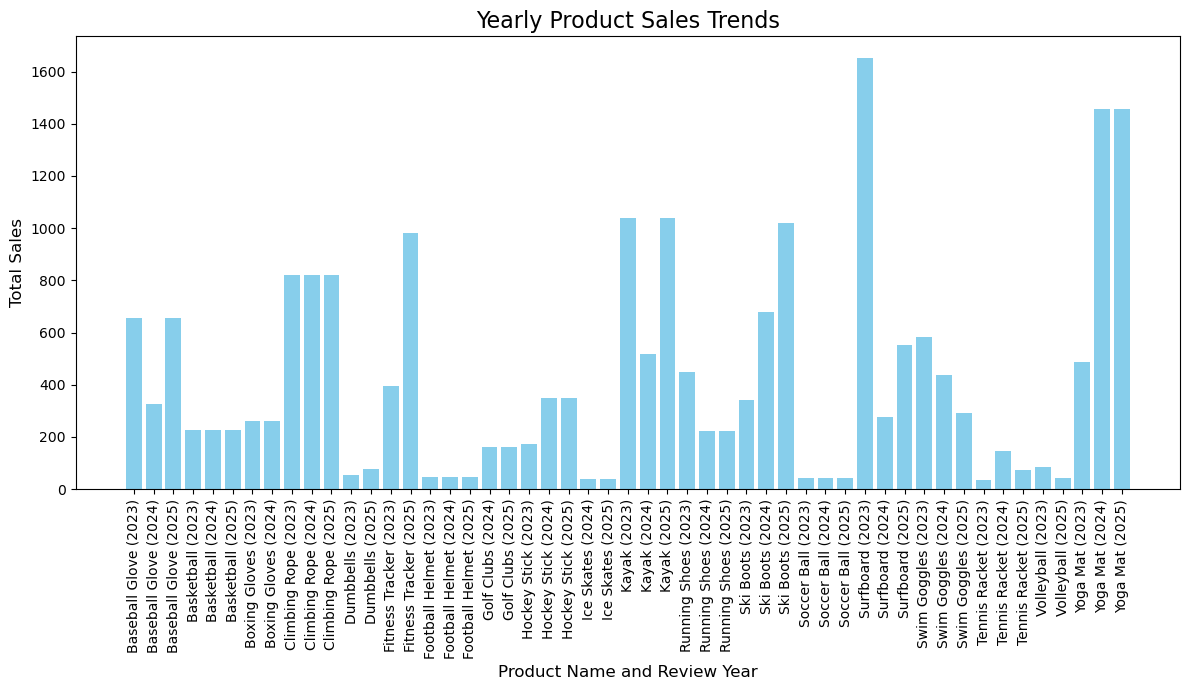

In [113]:
# Create a combined 'Product-ReviewYear' column for the x-axis
result['Product_ReviewYear'] = result['ProductName'] + ' (' + result['ReviewYear'].astype(str) + ')'

# Sort the result by 'Product_ReviewYear'
result_sorted = result.sort_values(by=['ProductName', 'ReviewYear'])

plt.figure(figsize=(12, 7))

# Plotting TotalSales by combined 'ProductName' and 'ReviewYear'
plt.bar(result_sorted['Product_ReviewYear'], result_sorted['TotalSales'], color='skyblue')

# Adding labels and title
plt.title('Yearly Product Sales Trends', fontsize=16)
plt.xlabel('Product Name and Review Year', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)

# Rotating the x-axis labels for better readability
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.show()


**Perform basic sentiment analysis in Python.**

In [35]:
Positive_sentiment =  ["The  quality  is    top-notch.",
                "Five  stars  for  the  quick  delivery.",
                "Customer  support  was  very  helpful.",
                "The  quality    is  top-notch.",
                "I  love  this  product,  will  buy  again!",
                "Excellent  product,  highly  recommend!",
                "Great  purchase,  very  satisfied.",
                "The  quality  is  top-notch.",
                "Amazing  value  for  the  price.",
                "I  love  this    product,  will  buy  again!",
                "Five  stars    for  the  quick  delivery.",
                "Exceeded  my    expectations!",
                "Excellent  product,    highly  recommend!",
                "Shipping  was  fast  and  the  item    was  well-packaged.",
                "Good  quality,  but  could    be  cheaper.",
                "Five  stars  for    the  quick  delivery.",
                "Customer  support  was    very  helpful.",
                "The  build  quality  is  impressive.",
                "Great  purchase,    very  satisfied.",
                "I  love  this  product,  will  buy    again!",
                "Exceeded  my  expectations!",
                "Shipping    was  fast  and  the  item  was  well-packaged.",
                "The    build  quality  is  impressive.",
                "Shipping  was  fast    and  the  item  was  well-packaged."]

In [36]:
Negative_sentiment = ["Product  did    not  meet  my  expectations.",
                "Not  worth  the  money.",
                "I  had  a  bad  experience  with  this  product.",
                "The  product  stopped  working  after  a  month.",
                "The  product    is  okay,  but  the  instructions  were  unclear.",
                "Disappointed  with  the  performance.",
                "The  product  is  okay,  but  the  instructions  were  unclear.",
                "The  product  arrived    late.",
                "Not    worth  the  money."]

In [37]:
 Neutral_sentiment = ["Average  experience,  nothing  special.",
                "Good  quality,  but  could  be  cheaper.",
                "Good  quality,  but  could  be    cheaper.",
                "Average  experience,  nothing    special."]

In [38]:
# Categorizing Sentiment into Positive/ negative/ neutral
def sentiment_categorize(txt):
  if txt in Positive_sentiment:
    return "Positive"
  elif txt in Negative_sentiment:
    return "Negative"
  else:
    return "Neutral"
      
customer_reviews['Sentiment']=customer_reviews['ReviewText'].apply(sentiment_categorize)

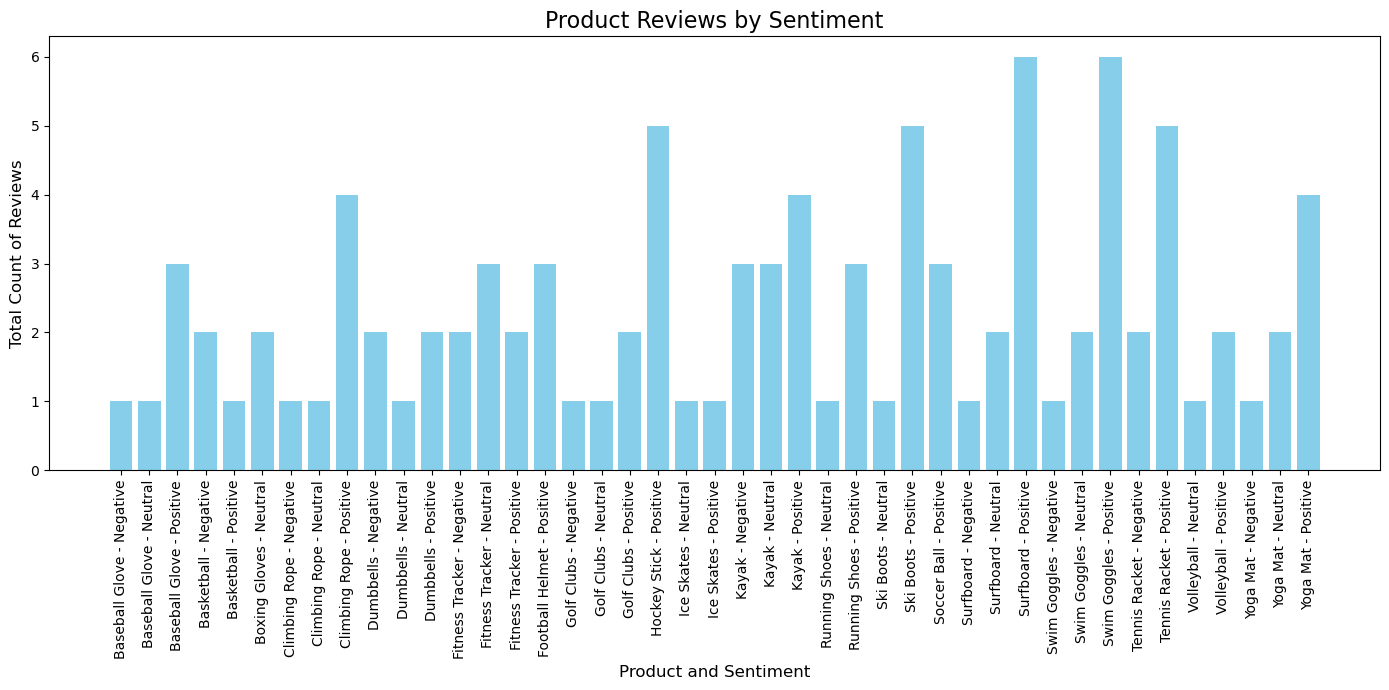

In [40]:
customer_reviewed_product = pd.merge(customer_reviews,products,how='inner',on='ProductID')
aggregated_data = customer_reviewed_product.groupby(['ProductName','Sentiment']).agg(TotalCount=('Sentiment','count')).reset_index()
aggregated_data['Product_Sentiment'] = aggregated_data['ProductName'] + ' - ' + aggregated_data['Sentiment']

# Create a bar chart
plt.figure(figsize=(14, 7))

# Plotting the bar chart: ProductName + Sentiment vs TotalCount
plt.bar(aggregated_data['Product_Sentiment'], aggregated_data['TotalCount'], color='skyblue')

# Adding labels and title
plt.title('Product Reviews by Sentiment', fontsize=16)
plt.xlabel('Product and Sentiment', fontsize=12)
plt.ylabel('Total Count of Reviews', fontsize=12)

# Rotating the x-axis labels for better readability
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.show()

**Correlate review trends with product performance.**

In [107]:
# merging customer_reviews and products tables
customer_review_products = pd.merge(customer_reviews,products,how='inner',on='ProductID')

Correlation between Rating and Total Sales: -0.008933959631324697


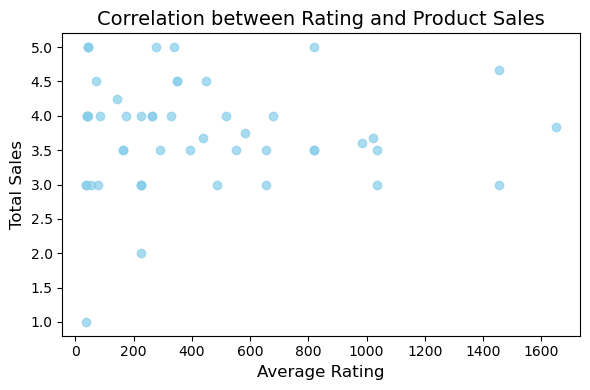

In [127]:
# calculate the correlation between 'Rating' and 'TotalSales'
correlation = result[['AverageRating', 'TotalSales']].corr().iloc[0, 1]
print(f"Correlation between Rating and Total Sales: {correlation}")

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(6, 4))

# Plotting the scatter plot between AverageRating and TotalSales
plt.scatter(result['TotalSales'],result['AverageRating'], color='skyblue', alpha=0.7)

# Adding labels and title
plt.title('Correlation between Rating and Product Sales', fontsize=14)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)

# Show the plot
plt.tight_layout()
plt.legend
plt.show()

## **5. Marketing Effectiveness (SQL):**

**Calculate customer retention rate.**

In [117]:
q = '''
WITH YearlyCustomers AS (
    SELECT 
        CustomerID,
        EXTRACT(YEAR FROM VisitDate) AS VisitYear
    FROM customer_journey
    GROUP BY CustomerID, EXTRACT(YEAR FROM VisitDate)
),
RetentionData AS (
    SELECT 
        yc1.VisitYear AS CurrentYear,
        COUNT(DISTINCT yc1.CustomerID) AS CustomersCurrentYear,
        COUNT(DISTINCT yc2.CustomerID) AS CustomersPreviousYear
    FROM YearlyCustomers yc1
    LEFT JOIN YearlyCustomers yc2 
        ON yc1.CustomerID = yc2.CustomerID
        AND (yc2.VisitYear = yc1.VisitYear - 1 OR yc2.VisitYear = yc1.VisitYear - 2)
    GROUP BY yc1.VisitYear
)
SELECT 
    CurrentYear,
    CustomersCurrentYear,
    CustomersPreviousYear,
    ROUND((CustomersPreviousYear * 100.0) / NULLIF(CustomersCurrentYear, 0), 2) AS RetentionRate
FROM RetentionData
ORDER BY CurrentYear;
'''
pd.read_sql_query(q, myconnection)

C:\Users\conta\AppData\Local\Temp\ipykernel_22236\707025921.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql_query(q, myconnection)


,CurrentYear,CustomersCurrentYear,CustomersPreviousYear,RetentionRate
0,2023,29,0,0.00
1,2024,27,8,29.63
2,2025,32,15,46.88


**Compare repeat vs. first-time buyers.**

In [135]:
# Repeatedly visited the webpage and Buying the Product
q = '''
with cte as (
	SELECT 
        J.CustomerID, C.CustomerName, C.Gender, C.Age, G.Country,count(*) over() as RepeatedCustomersTotal
    FROM customer_journey as J
    JOIN customers as C ON C.CustomerID = J.CustomerID
    JOIN geography as G ON G.GeographyID = C.GeographyID 
    GROUP BY J.CustomerID, C.CustomerName, C.Gender, C.Age, G.Country
    HAVING count(J.CustomerID) > 1
    ORDER BY J.CustomerID
)

SELECT cte.CustomerID, cte.CustomerName, cte.Gender, cte.Age, cte.Country, P.ProductName, J.VisitDate, J.Action, J.Duration 
FROM cte 
JOIN customer_journey J on J.CustomerID = cte.CustomerID
JOIN products P on P.ProductID = J.ProductID
WHERE J.Action='Purchase';
'''
pd.read_sql_query(q, myconnection)

C:\Users\conta\AppData\Local\Temp\ipykernel_17788\2214607389.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql_query(q, myconnection)


,CustomerID,CustomerName,Gender,Age,Country,ProductName,VisitDate,Action,Duration
0,42,John Gonzalez,Female,69,UK,Surfboard,2025-05-29,Purchase,261.0
1,58,Jane Williams,Male,34,Austria,Kayak,2024-07-06,Purchase,87.0


In [123]:
# First time visiting the webpage and Buying the Product
q = '''
with cte as (
	SELECT 
        J.CustomerID, C.CustomerName, C.Gender, C.Age, G.Country,count(*) over() as FirstTimeCustomersTotal
    FROM customer_journey as J
    JOIN customers as C ON C.CustomerID = J.CustomerID
    JOIN geography as G ON G.GeographyID = C.GeographyID 
    GROUP BY J.CustomerID, C.CustomerName, C.Gender, C.Age, G.Country
    HAVING count(J.CustomerID) = 1
    ORDER BY J.CustomerID
)

SELECT cte.CustomerID, cte.CustomerName, cte.Gender, cte.Age, cte.Country, P.ProductName, J.VisitDate, J.Action, J.Duration 
FROM cte 
JOIN customer_journey J on J.CustomerID = cte.CustomerID
JOIN products P on P.ProductID = J.ProductID
WHERE J.Action='Purchase';
'''
pd.read_sql_query(q, myconnection)

C:\Users\conta\AppData\Local\Temp\ipykernel_22236\1039145415.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql_query(q, myconnection)


,CustomerID,CustomerName,Gender,Age,Country,ProductName,VisitDate,Action,Duration
0,17,Daniel Thomas,Female,46,Germany,Fitness Tracker,2023-11-20,Purchase,137.0
1,46,Chris Johnson,Male,52,Spain,Surfboard,2025-06-15,Purchase,122.0
2,89,Alex Rodriguez,Male,22,Sweden,Climbing Rope,2025-10-27,Purchase,246.0
3,79,John Jones,Female,35,Netherlands,Climbing Rope,2025-03-09,Purchase,48.0


**Find best-performing products per region.**

In [151]:
q = '''
with cte as (
		SELECT G.Country, P.ProductName, count(P.ProductName) AS ProductCount,
		ROW_NUMBER() OVER(PARTITION BY G.country order by count(P.ProductName) DESC, P.ProductName) as newrank
		FROM customers AS C
		INNER JOIN customer_journey AS J ON J.CustomerID = C.CustomerID
		INNER JOIN geography AS G ON G.GeographyID = C.GeographyID
		INNER JOIN products AS P ON P.ProductID = J.ProductID
		group by G.Country, P.ProductName
)
SELECT Country, ProductName, ProductCount FROM cte
WHERE newrank = 1
ORDER BY Country;
'''
result = pd.read_sql_query(q, myconnection)
result

C:\Users\conta\AppData\Local\Temp\ipykernel_17788\282764594.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(q, myconnection)


,Country,ProductName,ProductCount
0,Austria,Boxing Gloves,3
1,Belgium,Fitness Tracker,2
2,France,Baseball Glove,1
3,Germany,Boxing Gloves,2
4,Italy,Golf Clubs,3
5,Netherlands,Climbing Rope,2
6,Spain,Football Helmet,3
7,Sweden,Boxing Gloves,1
8,Switzerland,Volleyball,3
9,UK,Hockey Stick,2


**Demographic Analysis**

In [129]:
q = '''
SELECT Gender, count(*) as 'No Of Customers' from customers as C
GROUP BY Gender
'''
result = pd.read_sql_query(q, myconnection)
result

C:\Users\conta\AppData\Local\Temp\ipykernel_22236\3724910259.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(q, myconnection)


,Gender,No Of Customers
0,Male,46
1,Female,54


In [133]:
q = '''
SELECT 
CASE
	when Age<18 Then 'Less than 18'
    when (Age>=18 and Age<=24) Then '18 to 24'
    when (Age>=25 and Age<=34) Then '25 to 34'
    when (Age>=35 and Age<=44) Then '35 to 44'
    when (Age>=45 and Age<=54) Then '45 to 54'
    when (Age>=55 and Age<=64) Then '55 to 64'
    when (Age>=65 and Age<=74) Then '65 to 74'
	else '75+'
END as Age_Range, count(*) as 'No Of Customers' from customers group by Age_Range order by 2 DESC;

'''
result = pd.read_sql_query(q, myconnection)
result

C:\Users\conta\AppData\Local\Temp\ipykernel_22236\2422725712.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(q, myconnection)


,Age_Range,No Of Customers
0,35 to 44,25
1,25 to 34,24
2,45 to 54,18
3,55 to 64,15
4,18 to 24,11
5,65 to 74,7


In [41]:
q = '''
SELECT G.Country, G.City, count(*) as 'No Of Customers'
FROM customers as C
INNER JOIN Geography as G on G.GeographyID = C.GeographyID
GROUP BY G.Country, G.City order by 3 DESC;
'''
result = pd.read_sql_query(q, myconnection)
result

C:\Users\vasan\AppData\Local\Temp\ipykernel_23104\9901135.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(q, myconnection)


,Country,City,No Of Customers
0,Spain,Madrid,18
1,Italy,Rome,12
2,Germany,Berlin,11
3,Austria,Vienna,10
4,UK,London,10
5,Netherlands,Amsterdam,9
6,Belgium,Brussels,9
7,Sweden,Stockholm,8
8,Switzerland,Zurich,8
9,France,Paris,5


In [8]:
#Close the connection
cursor.close()
myconnection.close()